In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision


In [41]:
img = torchvision.io.read_image("images t4/cyber-kitty.jpg")
img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([525, 800])


C:\Users\Arjun\AppData\Local\Temp\ipykernel_21428\2172645291.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


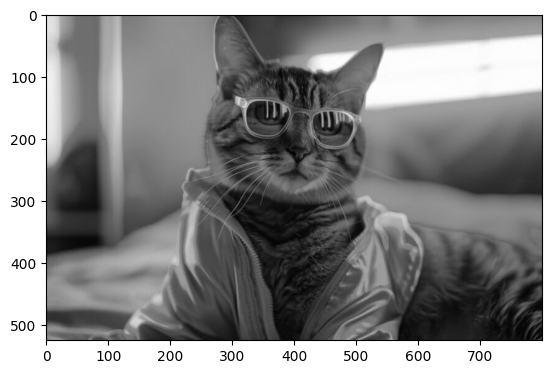

In [42]:
plt.imshow(img, cmap='gray')

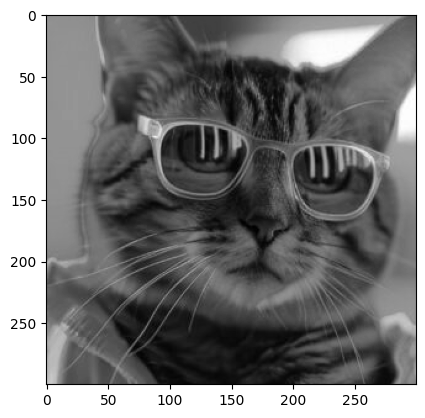

In [43]:
crop = torchvision.transforms.functional.crop(img, 50, 230, 300, 300)
plt.imshow(crop, cmap='gray')

In [44]:
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

In [45]:
masked_img = mask_image(crop, 0.3)

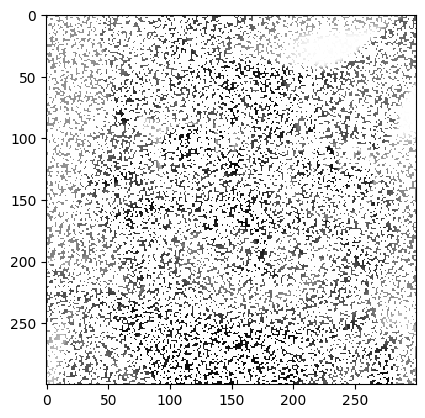

In [46]:
plt.imshow(masked_img[0], cmap='gray')

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [52]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [53]:
W, H, loss = factorize(masked_img[0], 50)

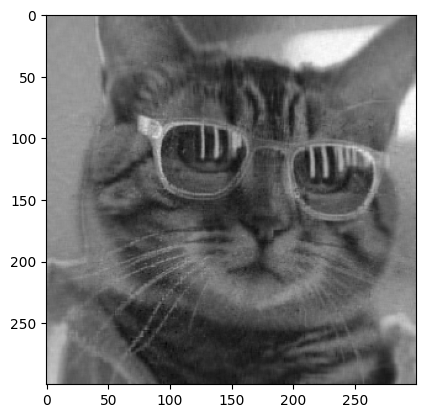

In [54]:
plt.imshow(torch.mm(W, H).cpu().detach().numpy(), cmap='gray')